In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.translate.chrf_score import sentence_chrf, corpus_chrf
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
from nltk.stem import *
# from nltk.stem.snowball import SnowballStemmer
from stemming.porter2 import stem
import stemming
from nltk.metrics.scores import recall

from nltk.corpus import stopwords

%matplotlib inline

In [2]:
from nmt_run import *

In [3]:
%run utils.ipynb

In [4]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [5]:
google_s2t_hyps, google_s2t_refs, google_s2t_refs_for_eval = get_google_data()
google_hyp_r0 = google_s2t_hyps['fisher_dev_r0']
google_dev_ref_0 = google_s2t_refs['fisher_dev_ref_0']

eval refs found, loading


In [89]:
# model_names = {
#     "simple": "emb_sp2enw/sp_0.33_seed-AA",
#     "sample_mix": "emb_sp2enw/sp_0.33_seed-AA_mix-0.5/",
# }

In [118]:
# model_names = {
#     "simple": "sp2enw_mel-80_vocab-nltk/sp_0.50_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln",
#     "sample_mix": "sp2enw_mel-80_vocab-nltk/sp_0.50_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln_sample/",
# }

In [119]:
model_names = {
    "simple": "sp2enw_mel-80_vocab-nltk/sp_0.33_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln",
    "sample_mix": "sp2enw_mel-80_vocab-nltk/sp_0.33_h-300_e-128_l2e-6_lstm_drpt-0.5_cnn-64-2-2_rnn-3_b-80-25_no-bn-ln_sample",
}

In [120]:
model_data = {}
for m, m_loc in model_names.items():
    model_data[m] ={"refs": {}, "hyps": {}, "refs_eval": {}, "log_train": [], "log_dev": []}
    model_data[m]["refs"] = pickle.load(open(os.path.join(m_loc, "model_s2t_refs.dict"), "rb"))
    model_data[m]["hyps"] = pickle.load(open(os.path.join(m_loc, "model_s2t_hyps.dict"), "rb"))
    model_data[m]["refs_eval"] = pickle.load(open(os.path.join(m_loc, "model_s2t_refs_for_eval.dict"), "rb"))
    model_data[m]["log_train"] = np.loadtxt(os.path.join(m_loc, "train.log"), delimiter=',', skiprows=False).transpose()
    model_data[m]["log_dev"] = np.genfromtxt(os.path.join(m_loc, "dev.log"), delimiter=',', usecols = (0,1,2)).transpose()

In [121]:
model_data["sample_mix"]["refs_eval"]['20051009_182032_217_fsp-A-1']

[['good', 'afternoon'],
 ['good', 'afternoon'],
 ['good', 'afternoon'],
 ['good', 'afternoon']]

In [122]:
model_data["sample_mix"]["refs"]['20051009_182032_217_fsp-A-1']

['good', 'afternoon']

In [123]:
model_data["sample_mix"]["hyps"]['20051009_182032_217_fsp-A-1']

['good', 'afternoon']

In [124]:
nltk.translate.bleu_score.sentence_bleu(model_data["sample_mix"]["refs_eval"]['20051009_182032_217_fsp-A-1'],
                                       model_data["sample_mix"]["hyps"]['20051009_182032_217_fsp-A-1'],
                                       smoothing_function=smooth_fun.method2)

0.7071067811865476

In [125]:
nltk.translate.bleu_score.sentence_bleu(model_data["simple"]["refs_eval"]['20051009_182032_217_fsp-A-1'],
                                       model_data["simple"]["hyps"]['20051009_182032_217_fsp-A-1'],
                                       smoothing_function=smooth_fun.method2)

0.7071067811865476

In [126]:
all_dev_utts= set(model_data["sample_mix"]["refs_eval"].keys()) & set(model_data["simple"]["refs_eval"].keys())

In [127]:
len(all_dev_utts)

3977

### Train, Dev loss and BLEU

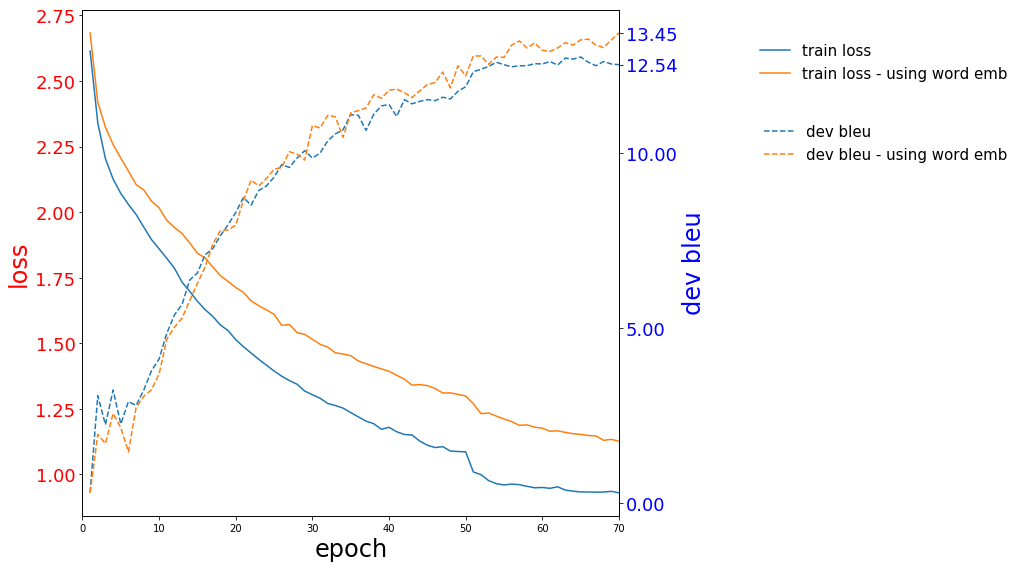

In [128]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,8)
ax1.plot(model_data["simple"]["log_train"][0], model_data["simple"]["log_train"][1], 
         color=tableau20[0], label="train loss")
ax1.plot(model_data["sample_mix"]["log_train"][0], model_data["sample_mix"]["log_train"][1], 
         color=tableau20[2], label="train loss - using word emb")
# ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(bbox_to_anchor=(1.75, 0.96), framealpha=0, fontsize=15)    
ax2 = ax1.twinx()
ax2.plot(model_data["simple"]["log_dev"][0], model_data["simple"]["log_dev"][2]*100, 
         color=tableau20[0], label="dev bleu", linestyle="--")
ax2.plot(model_data["sample_mix"]["log_dev"][0], model_data["sample_mix"]["log_dev"][2]*100,
         color=tableau20[2], label="dev bleu - using word emb", linestyle="--")
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)

# ax2.axhline(y=model_data["sample_mix"]["log_dev"][2][-1]*100, linewidth=1, color="k")
max_bleu_simple = model_data["simple"]["log_dev"][2][-1]*100
max_blue_mix = model_data["sample_mix"]["log_dev"][2][-1]*100

# plt.yticks(list(plt.yticks()[0]) + [max_bleu_simple, max_blue_mix])
plt.yticks(list(range(0,12,5)) + [max_bleu_simple, max_blue_mix])

ax1.set_xlim(0, model_data["simple"]["log_dev"][0][-1])
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(bbox_to_anchor=(1.75, 0.8), framealpha=0, fontsize=15)
# plt.legend(['dev bleu'], bbox_to_anchor=(1.06, 0.9), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

### Utterance level comparison

In [129]:
m_a = "simple"
m_b = "sample_mix"

In [130]:
MIN_LEN = 10

In [131]:
def check_bleu_with_len_filter(m_data, min_len):
    sel_refs, sel_hyps = [], []
    for u in m_data["refs_eval"]:
        len_ref = min([len(r) for r in m_data["refs_eval"][u]])
        if len_ref >= min_len:
            sel_refs.append(m_data["refs_eval"][u])
            sel_hyps.append(m_data["hyps"][u])
    print("{0:d} out of {1:d} have len >= {2:d}".format(len(sel_refs), len(m_data["refs_eval"]), min_len))
    bleu_score = corpus_bleu(sel_refs, sel_hyps, smoothing_function=smooth_fun.method2)*100
    print("BLEU={0:.2f}".format(bleu_score))
    sel_p, sel_r, _ = basic_precision_recall(sel_refs, sel_hyps)
    print("precision={0:.2f}, recall={1:.2f}".format(sel_p, sel_r))

In [132]:
check_bleu_with_len_filter(model_data[m_a], min_len=1)
check_bleu_with_len_filter(model_data[m_b], min_len=1)

3977 out of 3977 have len >= 1
BLEU=12.54
precision=46.71, recall=39.97
3977 out of 3977 have len >= 1
BLEU=13.38
precision=47.34, recall=41.31


In [133]:
check_bleu_with_len_filter(model_data[m_a], min_len=MIN_LEN)

1430 out of 3977 have len >= 10
BLEU=12.10
precision=46.53, recall=38.32


In [134]:
check_bleu_with_len_filter(model_data[m_b], min_len=MIN_LEN)

1430 out of 3977 have len >= 10
BLEU=13.02
precision=47.31, recall=39.86


In [135]:
utts_bleu = {m_a: {}, m_b: {}}

for utt in tqdm(all_dev_utts, ncols=80):
    utts_bleu[m_a][utt] = sentence_bleu(model_data[m_a]["refs_eval"][utt], 
                               model_data[m_a]["hyps"][utt], 
                               smoothing_function=smooth_fun.method2)
    utts_bleu[m_b][utt] = sentence_bleu(model_data[m_b]["refs_eval"][utt], 
                               model_data[m_b]["hyps"][utt], 
                               smoothing_function=smooth_fun.method2)

100%|██████████████████████████████████████| 3977/3977 [00:04<00:00, 868.32it/s]


In [136]:
all_above_min_len = 0
utts_a_better = []
utts_b_better = []

for utt in tqdm(all_dev_utts, ncols=80):
    if len(model_data[m_b]["refs"][utt]) > MIN_LEN:
        all_above_min_len += 1
        if utts_bleu[m_a][utt] > utts_bleu[m_b][utt]:
            utts_a_better.append(utt)
        elif utts_bleu[m_b][utt] > utts_bleu[m_a][utt]:
            utts_b_better.append(utt)

100%|███████████████████████████████████| 3977/3977 [00:00<00:00, 402314.10it/s]


In [137]:
len(utts_a_better), len(utts_b_better), all_above_min_len

(695, 797, 1506)

In [138]:
len(utts_b_better) - len(utts_a_better)

102

In [139]:
np.mean([utts_bleu[m_a][u]-utts_bleu[m_b][u] for u in utts_a_better])

0.05765650081783377

In [140]:
np.mean([utts_bleu[m_b][u]-utts_bleu[m_a][u] for u in utts_b_better])

0.06606251502197125

In [141]:
np.mean([len(model_data[m_a]["hyps"][u]) for u in utts_a_better]), np.std([len(model_data[m_a]["hyps"][u]) for u in utts_a_better])

(20.069064748201438, 7.921801707362517)

In [142]:
np.mean([len(model_data[m_b]["hyps"][u]) for u in utts_b_better]), np.std([len(model_data[m_b]["hyps"][u]) for u in utts_b_better])

(20.205771643663738, 8.229628927485999)

In [143]:
bleu_diff = {u: utts_bleu[m_b][u]-utts_bleu[m_a][u] for u in all_dev_utts if len(model_data[m_b]["refs"][u]) > MIN_LEN}

In [144]:
best_b = sorted(bleu_diff.items(), reverse=True, key=lambda t:t[1])[:10]

In [145]:
best_a = sorted(bleu_diff.items(), key=lambda t:t[1])[:10]

In [146]:
best_b

[('20051017_180712_270_fsp-B-2', 0.6959898522474196),
 ('20051019_210146_289_fsp-A-37', 0.4447425415521291),
 ('20051017_234550_276_fsp-A-50', 0.3815317201596056),
 ('20051023_232057_325_fsp-A-25', 0.37832420402973455),
 ('20051019_230329_292_fsp-B-24', 0.3674051443490537),
 ('20051018_210744_280_fsp-B-49', 0.3649561896763796),
 ('20051019_210146_289_fsp-B-32', 0.36449407090749486),
 ('20051010_212418_225_fsp-A-57', 0.35911068637571286),
 ('20051009_182032_217_fsp-B-32', 0.35775588620078086),
 ('20051009_182032_217_fsp-A-21', 0.3564543578480469)]

In [147]:
for u in best_b:
    display_pp = PrettyTable(["cat","sent"], hrules=True)
    display_pp.align = "l"
    display_pp.header = False

    ref_hyp = textwrap.fill(" ".join(model_data[m_b]["refs"][u[0]]),50)
    m_a_hyp = textwrap.fill(" ".join(model_data[m_a]["hyps"][u[0]]),50)
    m_b_hyp = textwrap.fill(" ".join(model_data[m_b]["hyps"][u[0]]),50)

    display_pp.add_row(["utt", u[0]])
    display_pp.add_row(["ref", ref_hyp])
    display_pp.add_row([m_a, m_a_hyp])
    display_pp.add_row([m_b, m_b_hyp])
    
    print(display_pp)

+------------+----------------------------------------------------+
| utt        | 20051017_180712_270_fsp-B-2                        |
+------------+----------------------------------------------------+
| ref        | greetings ah my name is jenny and i 'm calling     |
|            | from new york                                      |
+------------+----------------------------------------------------+
| simple     | well ah my name is my name is in new york          |
+------------+----------------------------------------------------+
| sample_mix | good ah my name is jenny and i 'm calling from new |
|            | york                                               |
+------------+----------------------------------------------------+
+------------+----------------------------------------------------+
| utt        | 20051019_210146_289_fsp-A-37                       |
+------------+----------------------------------------------------+
| ref        | because here in los angeles there

In [148]:
for u in best_a:
    display_pp = PrettyTable(["cat","sent"], hrules=True)
    display_pp.align = "l"
    display_pp.header = False

    ref_hyp = textwrap.fill(" ".join(model_data[m_b]["refs"][u[0]]),50)
    m_a_hyp = textwrap.fill(" ".join(model_data[m_a]["hyps"][u[0]]),50)
    m_b_hyp = textwrap.fill(" ".join(model_data[m_b]["hyps"][u[0]]),50)

    display_pp.add_row(["utt", u[0]])
    display_pp.add_row(["ref", ref_hyp])
    display_pp.add_row([m_a, m_a_hyp])
    display_pp.add_row([m_b, m_b_hyp])
    
    print(display_pp)

+------------+--------------------------------------------------+
| utt        | 20051026_211309_346_fsp-B-8                      |
+------------+--------------------------------------------------+
| ref        | oh yes i do n't know what they are going to do   |
|            | with that because they have                      |
+------------+--------------------------------------------------+
| simple     | ah yes i do n't know if you talk to that because |
|            | they want                                        |
+------------+--------------------------------------------------+
| sample_mix | no if you want to talk about this because they   |
|            | want to                                          |
+------------+--------------------------------------------------+
+------------+---------------------------------------------+
| utt        | 20051019_230329_292_fsp-A-3                 |
+------------+---------------------------------------------+
| ref        | ah i am i 

In [149]:
nltk.translate.bleu_score.sentence_bleu(model_data["sample_mix"]["refs_eval"]['20051009_182032_217_fsp-A-1'],
                                       model_data["sample_mix"]["hyps"]['20051009_182032_217_fsp-A-1'],
                                       smoothing_function=smooth_fun.method2)

0.7071067811865476

### sp_0.33 experiments

### Dev set performance 
```
_no sample
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
********** dev bleu=0.1254
********** dev: prec=46.709, recall=40.369

_sample
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
********** dev bleu=0.1338
********** dev: prec=47.333, recall=41.707
```
### Test set performance 

```
_no sample
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
********** test bleu=0.1211
********** test: prec=46.556, recall=40.643


_sample
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
********** test bleu=0.1265
********** test: prec=46.967, recall=41.969
```